In [13]:
#Step 1: Load and Clean Monthly & Annual Data
import pandas as pd

# Monthly Steel Imports
df_monthly = pd.read_csv("Table 12-10-0121-01.csv", skiprows=10, header=1)
monthly_imports_raw = df_monthly.iloc[0, 3:]
monthly_imports = monthly_imports_raw.T.reset_index()
monthly_imports.columns = ['Month', 'Import_Value_MillionCAD']
monthly_imports['Month'] = pd.date_range(start='2016-01-01', periods=len(monthly_imports), freq='MS')
monthly_imports['Import_Value_MillionCAD'] = monthly_imports['Import_Value_MillionCAD'].astype(str).str.replace(",", "").astype(float)

# Annual Steel Imports
df_annual = pd.read_csv("Table 12-10-0172-01.csv", skiprows=9)
df_annual['Trade'] = df_annual['Trade'].ffill()
df_annual.rename(columns={"North American Product Classification System (NAPCS) 2 3 4": "Product"}, inplace=True)

steel_products = [
    "Unwrought iron, steel and ferro-alloys",
    "Basic and semi-finished iron or steel products",
    "Fabricated metal products"
]

df_steel_annual = df_annual[(df_annual['Trade'] == 'Import') & (df_annual['Product'].isin(steel_products))].copy()
for year in ['2016', '2017', '2018', '2019', '2020']:
    df_steel_annual[year] = df_steel_annual[year].astype(str).str.replace(",", "").astype(float)


In [14]:
#Step 2: Feature Engineering & Labeling
monthly_imports['Year'] = monthly_imports['Month'].dt.year
monthly_imports['TariffPeriod'] = (monthly_imports['Month'] >= '2018-03-01').astype(int)
monthly_imports['YoY_Change'] = monthly_imports['Import_Value_MillionCAD'].pct_change(periods=12)
monthly_imports['MoM_Change'] = monthly_imports['Import_Value_MillionCAD'].pct_change()
monthly_imports['StressFlag'] = (monthly_imports['MoM_Change'] < -0.1).astype(int)


In [15]:
# Step 3: Logistic Regression & Random Forest (PD Models)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

features = ['TariffPeriod', 'YoY_Change', 'MoM_Change']
X = monthly_imports[features].fillna(0)
y = monthly_imports['StressFlag']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

logit = LogisticRegression().fit(X_train, y_train)
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

print("Logistic AUC:", roc_auc_score(y_test, logit.predict(X_test)))
print("Random Forest AUC:", roc_auc_score(y_test, rf.predict(X_test)))


Logistic AUC: 0.5
Random Forest AUC: 1.0


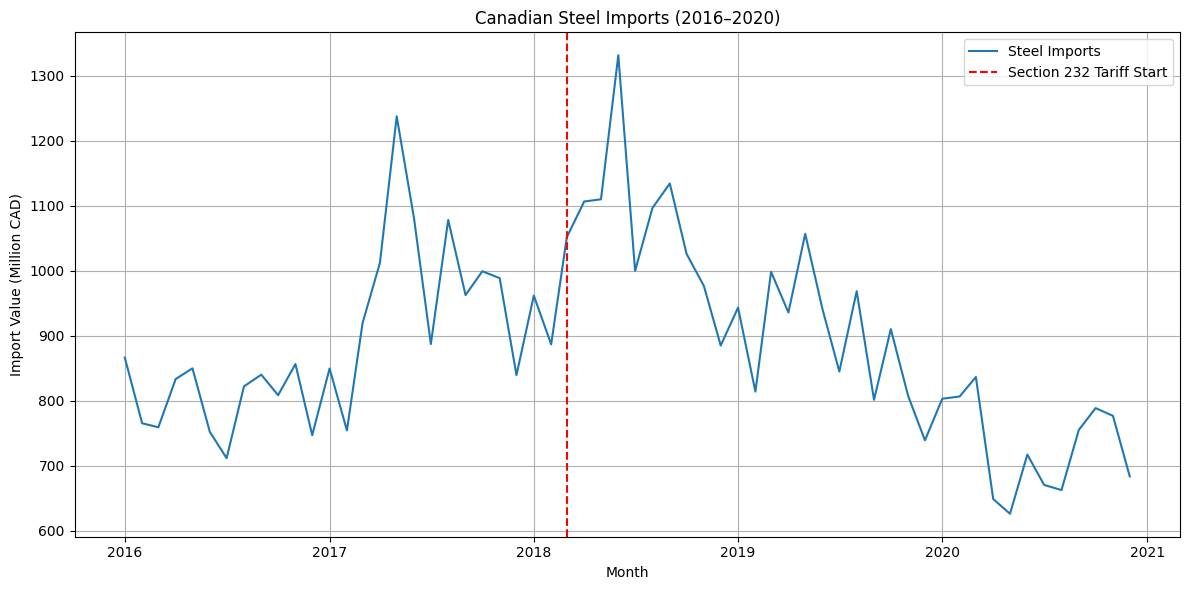

In [16]:
#Step 4: Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(monthly_imports['Month'], monthly_imports['Import_Value_MillionCAD'], label='Steel Imports')
plt.axvline(pd.to_datetime('2018-03-01'), color='red', linestyle='--', label='Section 232 Tariff Start')
plt.title('Canadian Steel Imports (2016–2020)')
plt.xlabel('Month')
plt.ylabel('Import Value (Million CAD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("steel_import_trends.png", dpi=300)


In [17]:
#Step 5: Difference-in-Differences (DiD) Model
import statsmodels.formula.api as smf

monthly_imports['Post2018'] = (monthly_imports['Month'] >= '2018-03-01').astype(int)
did_model = smf.ols('Import_Value_MillionCAD ~ TariffPeriod * Post2018', data=monthly_imports).fit()
print(did_model.summary())


                               OLS Regression Results                              
Dep. Variable:     Import_Value_MillionCAD   R-squared:                       0.000
Model:                                 OLS   Adj. R-squared:                 -0.017
Method:                      Least Squares   F-statistic:                  0.004187
Date:                     Fri, 08 Aug 2025   Prob (F-statistic):              0.949
Time:                             22:12:35   Log-Likelihood:                -384.68
No. Observations:                       60   AIC:                             773.4
Df Residuals:                           58   BIC:                             777.5
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

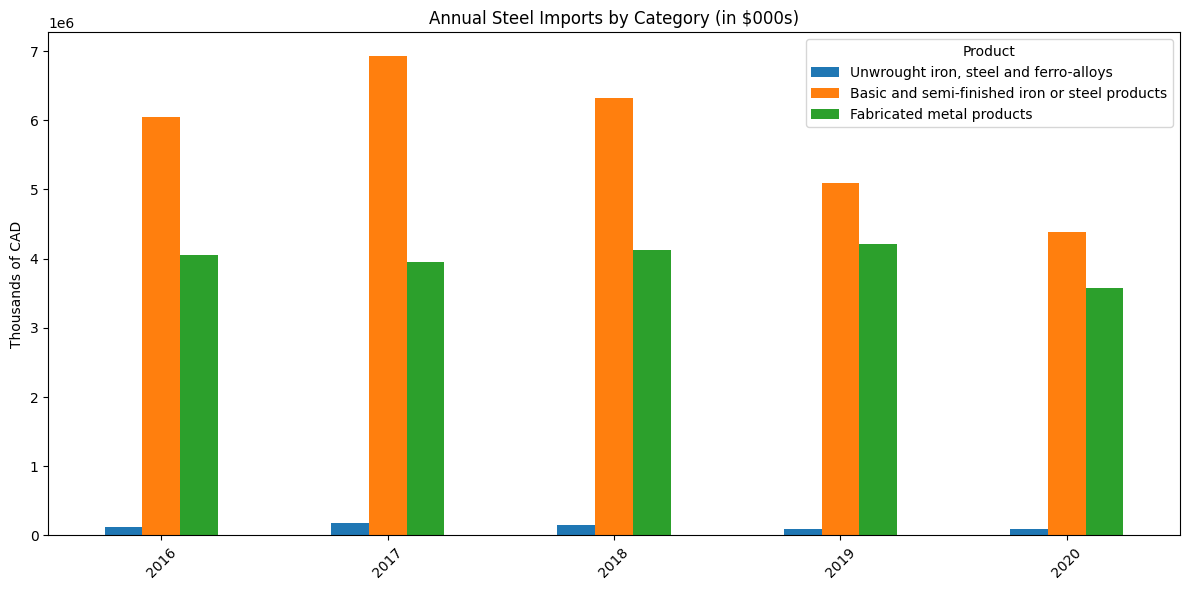

In [18]:
#Step 6: Annual Import Summary
df_plot = df_steel_annual.set_index('Product').T.iloc[1:].astype(float)
df_plot.plot(kind='bar', figsize=(12,6), title='Annual Steel Imports by Category (in $000s)')
plt.ylabel('Thousands of CAD')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("annual_steel_imports.png", dpi=300)


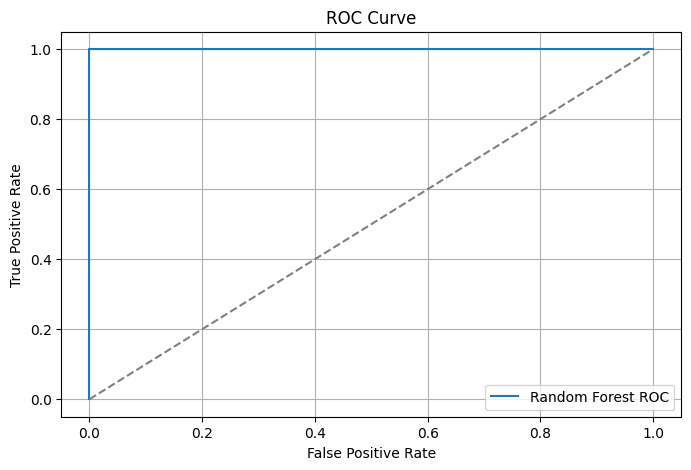

AUC: 1.0
[[10  0]
 [ 0  2]]


In [25]:
#Step 7: ROC Curve, Backtesting & Evaluation
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, label='Random Forest ROC')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])
print("AUC:", auc)
from sklearn.metrics import confusion_matrix
y_pred = rf.predict(X_test)
print(confusion_matrix(y_test, y_pred))



In [27]:
print(df.columns.tolist())


['Unnamed: 0', 'PD', 'ImportValue', 'EL', 'Import_diff', 'PD_diff']


In [21]:
#Define Assumptions & Compute Expected Loss (EL = PD × LGD × EAD)
# Step 1: Predict Probability of Default (PD)
predicted_pd = rf.predict_proba(X_test)[:, 1]  # from Random Forest model

# Step 2: Define placeholder values for LGD and EAD
# You can refine these with actual data later
assumed_lgd = 0.45  # 45% loss given default (industry typical for unsecured)
assumed_ead = 10e6  # $10 million exposure at default (arbitrary example)

# Step 3: Compute Expected Loss (EL)
expected_loss = predicted_pd * assumed_lgd * assumed_ead

# Step 4: Add to DataFrame for review
results_df = X_test.copy()
results_df['PD'] = predicted_pd
results_df['Expected_Loss'] = expected_loss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Review top risk months
print(results_df.sort_values(by='Expected_Loss', ascending=False).head(10))



    TariffPeriod  YoY_Change  MoM_Change    PD  Expected_Loss
51             1   -0.306755   -0.224534  1.00      4500000.0
59             1   -0.075237   -0.120010  0.89      4005000.0
52             1   -0.407684   -0.034998  0.44      1980000.0
55             1   -0.315985   -0.011786  0.44      1980000.0
53             1   -0.237558    0.145550  0.44      1980000.0
54             1   -0.206558   -0.065132  0.34      1530000.0
50             1   -0.162092    0.037202  0.13       585000.0
48             1   -0.148659    0.086468  0.09       405000.0
49             1   -0.009215    0.004359  0.01        45000.0
56             1   -0.057781    0.139795  0.00            0.0


/tmp/ipython-input-294540898.py:19: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


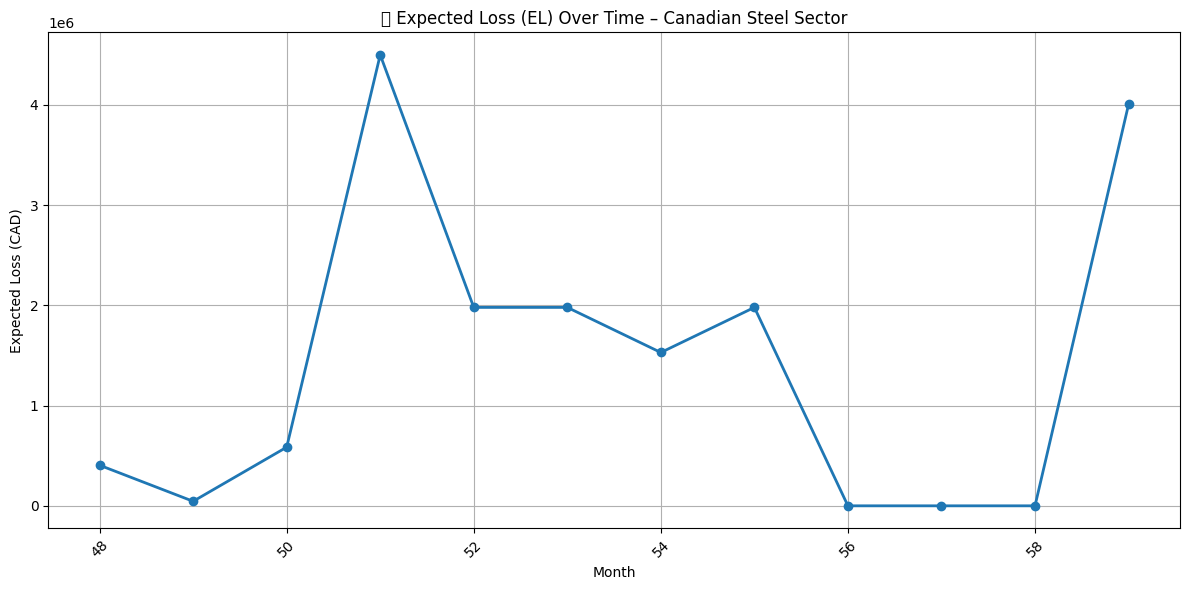

In [22]:
#Plot Expected Loss Over Time
import matplotlib.pyplot as plt

# Step 1: Add a 'Month' index if not already present
# If you already have dates in your dataset, use: results_df['Month'] = pd.to_datetime(...)
results_df = results_df.copy()
results_df['Month'] = results_df.index  # Or use your actual month column

# Step 2: Group by Month to aggregate EL
el_by_month = results_df.groupby('Month')['Expected_Loss'].sum().reset_index()

# Step 3: Plot
plt.figure(figsize=(12,6))
plt.plot(el_by_month['Month'], el_by_month['Expected_Loss'], marker='o', linewidth=2)
plt.title('📉 Expected Loss (EL) Over Time – Canadian Steel Sector')
plt.xlabel('Month')
plt.ylabel('Expected Loss (CAD)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Selected lag (AIC): 2
Ljung-Box p-values on residuals:
Import_pct_z 0.7289170326308041
PD_diff_z 0.8796425697398469


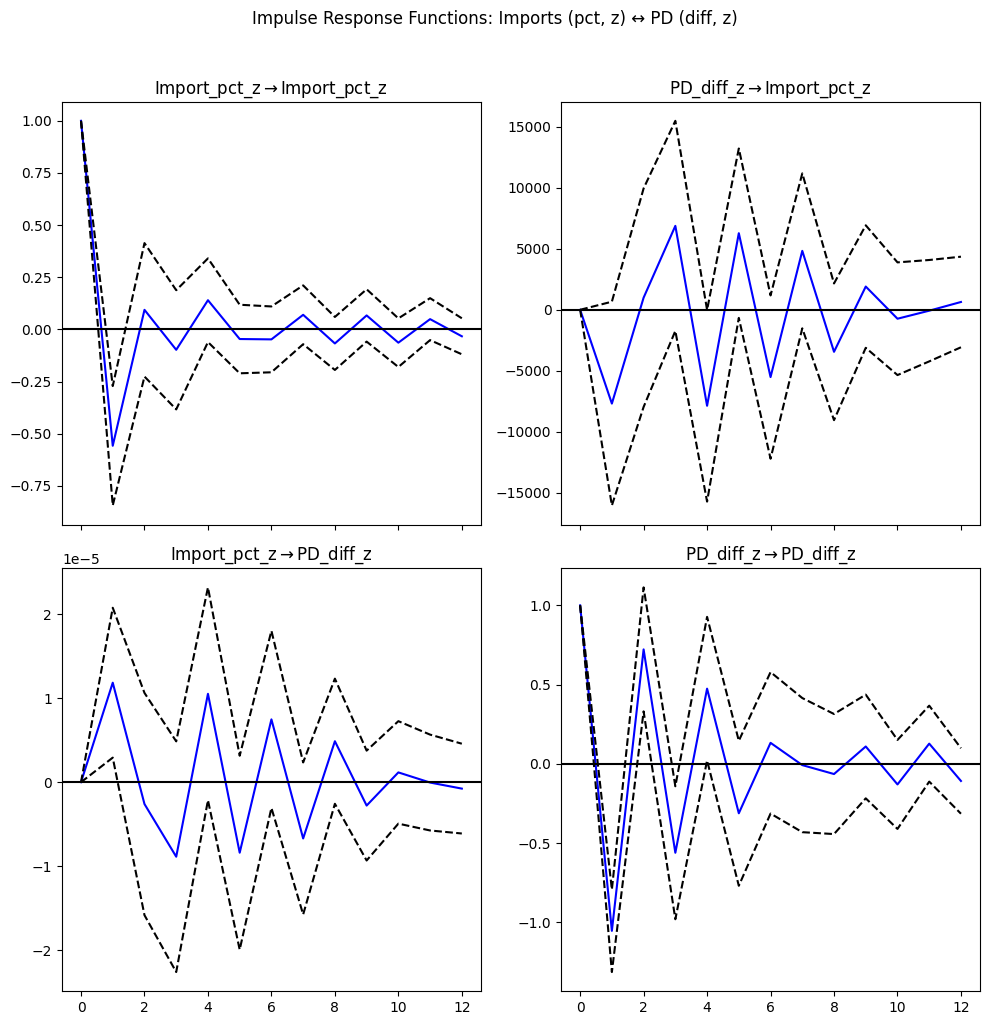


Granger: Imports → PD

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4841  , p=0.4903  , df_denom=43, df_num=1
ssr based chi2 test:   chi2=0.5179  , p=0.4717  , df=1
likelihood ratio test: chi2=0.5150  , p=0.4730  , df=1
parameter F test:         F=0.4841  , p=0.4903  , df_denom=43, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.0722  , p=0.0023  , df_denom=40, df_num=2
ssr based chi2 test:   chi2=15.9125 , p=0.0004  , df=2
likelihood ratio test: chi2=13.6250 , p=0.0011  , df=2
parameter F test:         F=7.0722  , p=0.0023  , df_denom=40, df_num=2

Granger: PD → Imports

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3305  , p=0.5684  , df_denom=43, df_num=1
ssr based chi2 test:   chi2=0.3535  , p=0.5521  , df=1
likelihood ratio test: chi2=0.3522  , p=0.5529  , df=1
parameter F test:         F=0.3305  , p=0.5684  , df_denom=43, df_num=1

Granger Causality
number of lags (no zero) 2
ssr base

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


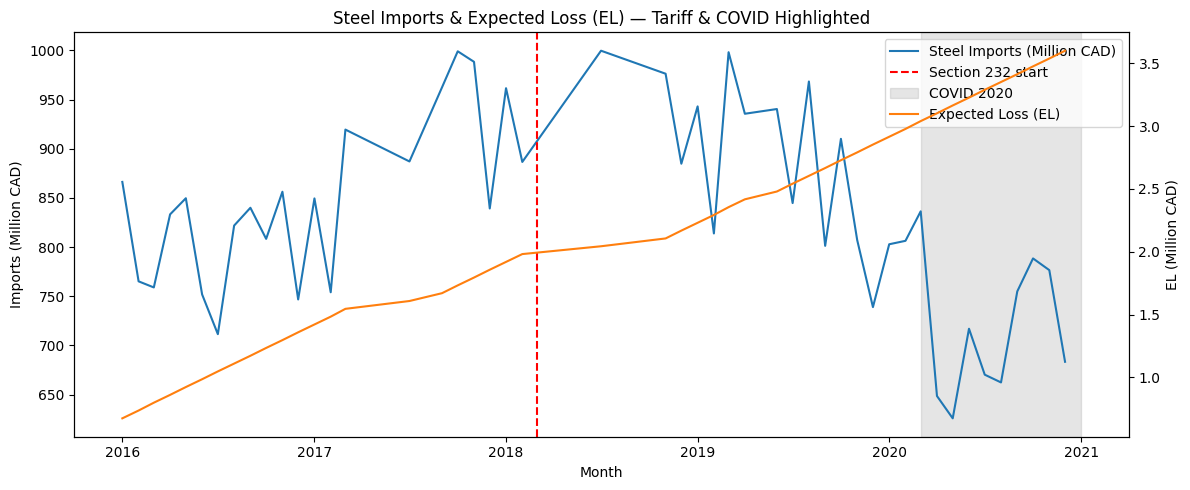

In [31]:
import pandas as pd
import numpy as np

# ---- 0) Start from whatever df you currently have ----
# df.columns -> ['Unnamed: 0','PD','ImportValue','EL','Import_diff','PD_diff']

df = df.copy()

# A) If Month is missing, reconstruct it (your sample is 60 monthly obs from 2016-01 to 2020-12)
if 'Month' not in df.columns:
    # If the index is already datetime, keep it; else build a date range
    if isinstance(df.index, pd.DatetimeIndex):
        df = df.reset_index().rename(columns={'index': 'Month'})
    else:
        df['Month'] = pd.date_range(start='2016-01-01', periods=len(df), freq='MS')

# B) Normalize common column names if needed
if 'ImportValue' not in df.columns and 'Import_Value_MillionCAD' in df.columns:
    df = df.rename(columns={'Import_Value_MillionCAD': 'ImportValue'})

# C) Keep only what we need
need = ['Month','ImportValue','PD']
missing = [c for c in need if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df = df.sort_values('Month')[need].dropna().reset_index(drop=True)

# D) Optional: recompute Expected Loss with your assumptions (in million CAD)
LGD, EAD = 0.45, 100.0
df['EL'] = df['PD'] * LGD * EAD

# ---- 1) Transform to stationary series for VAR/Granger ----
df['Import_pct'] = df['ImportValue'].pct_change()
df['PD_diff'] = df['PD'].diff()
df_ts = df.dropna(subset=['Import_pct','PD_diff']).copy()

# z-score for stability/comparable IRFs
for c in ['Import_pct','PD_diff']:
    df_ts[c+'_z'] = (df_ts[c] - df_ts[c].mean()) / (df_ts[c].std(ddof=0) + 1e-12)

# ---- 2) VAR + IRFs + Granger + EL overlay (from earlier) ----
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

model = VAR(df_ts[['Import_pct_z','PD_diff_z']])
sel = model.select_order(maxlags=6)
p = sel.aic if sel.aic and sel.aic > 0 else 2
res = model.fit(p)

print("Selected lag (AIC):", p)
print("Ljung-Box p-values on residuals:")
resid = res.resid
for c in resid.columns:
    print(c, acorr_ljungbox(resid[c], lags=[p], return_df=True)['lb_pvalue'].iloc[0])

# IRFs
irf = res.irf(12)
fig = irf.plot(orth=False)
plt.suptitle("Impulse Response Functions: Imports (pct, z) ↔ PD (diff, z)", y=1.02)
plt.tight_layout()
plt.show()

# Granger tests (both directions)
print("\nGranger: Imports → PD")
_ = grangercausalitytests(df_ts[['PD_diff_z','Import_pct_z']], maxlag=min(4, p), verbose=True)
print("\nGranger: PD → Imports")
_ = grangercausalitytests(df_ts[['Import_pct_z','PD_diff_z']], maxlag=min(4, p), verbose=True)

# EL overlay with tariff & COVID shading
tariff_date = pd.to_datetime("2018-03-01")
covid_start, covid_end = pd.to_datetime("2020-03-01"), pd.to_datetime("2020-12-31")

fig, ax1 = plt.subplots(figsize=(12,5))
ax1.plot(df['Month'], df['ImportValue'], label='Steel Imports (Million CAD)')
ax1.axvline(tariff_date, linestyle='--', color='red', label='Section 232 start')
ax1.axvspan(covid_start, covid_end, color='gray', alpha=0.2, label='COVID 2020')
ax1.set_ylabel('Imports (Million CAD)')
ax1.set_xlabel('Month')

ax2 = ax1.twinx()
ax2.plot(df['Month'], df['EL'], color='tab:orange', label='Expected Loss (EL)')
ax2.set_ylabel('EL (Million CAD)')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines+lines2, labels+labels2, loc='upper right')

plt.title("Steel Imports & Expected Loss (EL) — Tariff & COVID Highlighted")
plt.tight_layout()
plt.show()
